In [1]:
!pip install medmnist
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import torch
import time
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import statistics as stat
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.models as models
from torchvision import transforms as tt
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
from utils import load_npz_files, get_indexes_of_test, Dataset_Preprocessing, data_check_plot_tensor_figures, torch_plot_tensor_figures
from encoding import AutoEncoder, Trim, Reshape

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
current_dir = os.getcwd()
derma = load_npz_files(current_dir + '/dermamnist.npz')
test_data = derma['test_images']
test_label = derma['test_labels']

index_ = get_indexes_of_test(derma)

torch.cuda.is_available(): True


In [4]:
# image_0 = test_data[index_[0]]
# image0 = Dataset_Preprocessing(image_0)
# label_0 = test_label[index_[0]]
# test0 = list(zip(image0, label_0))

# def zip_list(index, selected_label):
#     image_ = test_data[index[selected_label]]
#     image = Dataset_Preprocessing(image_)
#     label_ = test_label[index[selected_label]]
#     return list(zip(image, label_))

In [5]:
def visual(index, selected_label, batch_size):
    image_ = test_data[index[selected_label]]
    image_tensor = Dataset_Preprocessing(image_)
    return DataLoader(dataset=image_tensor, batch_size=batch_size)

In [6]:
visual0 = visual(index_, 0, 32)
visual1 = visual(index_, 1, 32)
visual2 = visual(index_, 2, 32)
visual3 = visual(index_, 3, 32)
visual4 = visual(index_, 4, 32)
visual5 = visual(index_, 5, 32)
visual6 = visual(index_, 6, 32)

# A visualizaiton for real/fake images distributions
* true images from the dataset
* nWS WGANgp, classifier predicted, 
* Ws DCgan, classifier predicted

# Model needed
* true dataset
* DCGAN5 architecture
    * nWS_WGANGP_l100_lr00001_epoch1000.pt
    * WS_DCGAN_l100_lr00001_epoch500.pt


# Real images for different labels

In [7]:
# make_grid is a very nice function in torchvision
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataset, nmax=32):
    for images in dataset:
        show_images(images, nmax)
        break

In [8]:
# show_batch(visual0)
# show_batch(visual1)
# show_batch(visual2)
# show_batch(visual3)
# show_batch(visual4)
# show_batch(visual5)
# show_batch(visual6)

In [9]:
# 04/05
# dcgan with reshape in generator, 5conv in both gen and disc
class DC_GAN_5(torch.nn.Module):
        
    # latent dimension is for noise sampling
    def __init__(self, latent_dimension, image_height, image_width, color_channels): 
        super().__init__()
        self.latent_dimension = latent_dimension
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        # 5 conv layers
        self.generator = nn.Sequential(
            torch.nn.Linear(self.latent_dimension,256),
            torch.nn.Unflatten(1,(16,4,4)),
            torch.nn.ConvTranspose2d(in_channels=16,
                                     out_channels=4*self.image_height,
                                     kernel_size=(4,4),
                                     stride=(2,2),
                                     padding=2
            ),
            torch.nn.BatchNorm2d(4*self.image_height),
            # Relu or LeakyReLU remains for test
            torch.nn.LeakyReLU(),

            torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
                                     out_channels=8*self.image_height,
                                     kernel_size=(3,3),
                                     stride=(2,2),
                                     padding=2
                                    ),
            torch.nn.BatchNorm2d(8*self.image_height),
            torch.nn.LeakyReLU(),
            
            torch.nn.ConvTranspose2d(in_channels=8*self.image_height,
                                     out_channels=4*self.image_height,
                                     kernel_size=(3,3),
                                     stride=(2,2),
                                     padding=2
                                    ),  
            torch.nn.BatchNorm2d(4*self.image_height),
            torch.nn.LeakyReLU(),

            torch.nn.ConvTranspose2d(in_channels=4*self.image_height,
                                     out_channels=2*self.image_height,
                                     kernel_size=(3,3),
                                     stride=(2,2),
                                     padding=2
            ),
            torch.nn.BatchNorm2d(2*self.image_height),
            torch.nn.LeakyReLU(),

            torch.nn.ConvTranspose2d(in_channels=2*self.image_height,
                                     out_channels=self.color_channels,
                                     kernel_size=(2,2),
                                     stride=(1,1),
                                     padding=0
            ),
            torch.nn.Tanh()
            # torch.nn.Sigmoid() # [N, 3, 28, 28]
        )

        # Lets use fully convolutional network
        # 5 convs
        self.discriminator = nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=32,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                           ),
            # torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(0.2, inplace=True), 
            # dropout are for test
            # torch.nn.Dropout2d(p=0.5),
            torch.nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                           ),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True), 
            # torch.nn.Dropout2d(p=0.5),
            
            torch.nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                            ),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(in_channels=128,
                            out_channels=64,
                            kernel_size=(3,3),
                            stride=(2,2),
                            padding=1
                           ),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True), 
            
            torch.nn.Conv2d(in_channels=64,
                            out_channels=1,
                            kernel_size=(4,4),
                            stride=(1,1),
                            padding=1
                           ),
            torch.nn.Flatten(),
            # torch.nn.Tanh(),
      
        )
        
    def generator_forward(self, z):
        img = self.generator(z)
        return img
        
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits
        

In [10]:
# classifier model
# the classifier designed by myself
# dropout 0.2, ... 
# epoch200, lr: 0.0001, acc: 0.75, loss: 0.73
# name: WS_Classifier1_bs32_lr00001_7573.pt

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(32, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=4, stride=2),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=4, stride=2),
            )         
             
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),
            # nn.Sigmoid()
            )
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Load classifier models

In [11]:
classifier = Net(in_channels=3, num_classes=7)
# classifier.load_state_dict(torch.load('/content/nWS_Classifier1_bs32_lr00001_7568.pt'))
# classifier.load_state_dict(torch.load('/content/WSv0_Classifier1_bs32_lr00001_6495.pt'))
# classifier.load_state_dict(torch.load('/content/WSv1_Classifier1_bs32_lr00001_7573.pt'))
classifier.load_state_dict(torch.load('/content/WSv2_Classifier1_bs32_lr00001_7374.pt'))
# classifier.cuda()
classifier.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=12

# True images

In [12]:
# true images
data_flag = 'dermamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
# image transform
tensor_transform = tt.Compose([tt.ToTensor(),])
# derma test
derma_test_dataset = DataClass(split='test', transform=tensor_transform, download=download)
test_loader = DataLoader(dataset=derma_test_dataset, batch_size=32, shuffle=False)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz


# Distribution: true VS. predict true 

In [13]:
loss_function = nn.CrossEntropyLoss()
test_acc_batch=0
test_loss_batch=0
pred_test = []
test_label = []
classifier.eval()
for images,labels in test_loader:
    batch_size = labels.shape[0]
    labels = labels.to(torch.int64).view(-1)
    # if torch.cuda.is_available():
    #     images = images.cuda()
    #     labels = labels.cuda()
    test_label.append(labels)

    out = classifier(images)

    test_loss = loss_function(out, labels)
    test_loss_batch += test_loss.item()
            
    _, pred_ = torch.max(out, axis=1)
    pred_test.append(pred_)
    score_test = (pred_ == labels).sum()
    score_acc = score_test/batch_size
    test_acc_batch += score_acc

test_acc = test_acc_batch/len(test_loader)
test_loss = test_loss_batch/len(test_loader)

print('test accuracy is: ', test_acc)
print('test loss is: ', test_loss)

pred_labels = []
for i in range(len(pred_test)):
    for j in pred_test[i]:
        pred_labels.append(j.cpu().item())
test_labels = []
for i in range(len(test_label)):
    for j in test_label[i]:
        test_labels.append(j.cpu().item())
pred_counts = pd.Series(pred_labels).value_counts()
true_counts = pd.Series(test_labels).value_counts()

test accuracy is:  tensor(0.7318)
test loss is:  0.7726457421741788


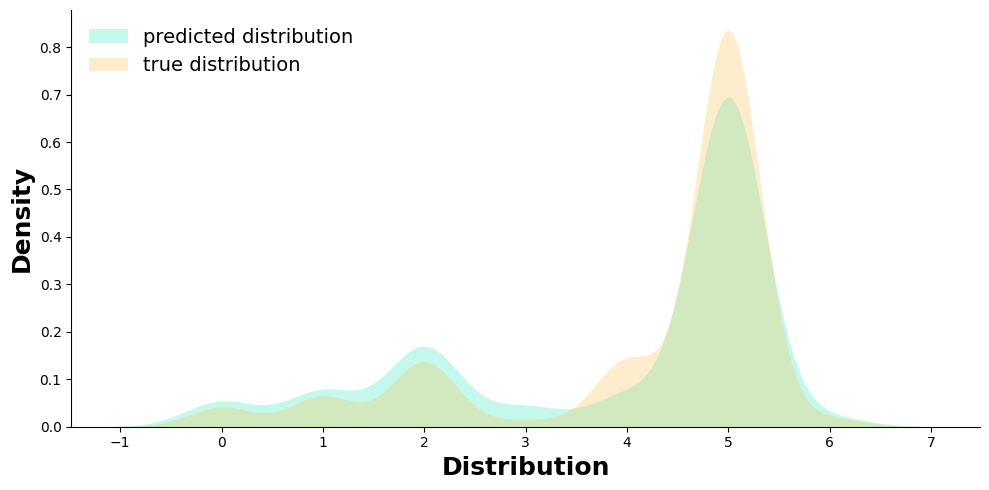

In [14]:
# Create a color palette
colors = sns.color_palette("turbo", 2)

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'predicted test dataset distribution': pred_labels, 'Derma test dataset distribution': test_labels}),
                  aspect=2, height=5, palette='husl')
g.map(sns.kdeplot, 'predicted test dataset distribution', color=colors[0], fill=True, lw=0, label='predicted distribution')
g.map(sns.kdeplot, 'Derma test dataset distribution', color=colors[1], fill=True, lw=0, label='true distribution')


# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize=14, frameon=False, edgecolor='black')
plt.xlabel('Distribution', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# distribution: predict DC generated

In [15]:
# image size
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 3

# hyper-parameters
RANDOM_SEED = 923
LATENT_DIMENSION= 100

# load model
DCgan = DC_GAN_5(latent_dimension=LATENT_DIMENSION,
              image_height=IMAGE_HEIGHT, 
              image_width=IMAGE_WIDTH, 
              color_channels=IMAGE_CHANNELS
             )

DCgan.load_state_dict(torch.load('/content/WS_DCGAN_l100_lr00001_epoch500.pt'))
DCgan.to(DEVICE)

DC_GAN_5(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 4, 4))
    (2): ConvTranspose2d(16, 112, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose2d(112, 224, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(224, 112, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): ConvTranspose2d(112, 56, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (12): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(ne

In [67]:
'''
generate fake images
'''
import random
manualSeed = 923
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

# generation images 
generation_size = 10000

# adjust the latent dimension accordingly
fixed_noise = torch.randn(generation_size, 100, device=DEVICE)

dc_fake_images = DCgan.generator_forward(fixed_noise).detach().cpu()
print(dc_fake_images.shape) # (3000, 3, 28, 28)
# type(dc_fake_images) # tensor

# hyper parameters
BATCH_SIZE = 32

# batch size 32
DC_generated_derma = DataLoader(dc_fake_images, 
                         batch_size = BATCH_SIZE, 
                         num_workers=0,
                         shuffle=True)
# fake data is prepared

Random Seed:  923
torch.Size([10000, 3, 28, 28])


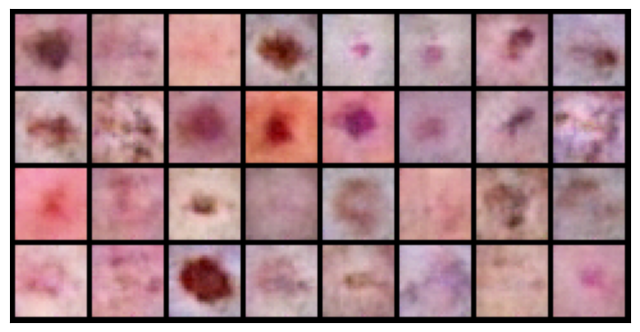

In [68]:
show_batch(DC_generated_derma)

In [69]:
# predicted labels
DC_pred_label = []
classifier.eval()
for i, generated_images in enumerate(DC_generated_derma):
    # if torch.cuda.is_available():
    #     generated_images = generated_images.cuda()

    out = classifier(generated_images)
            
    _, pred_ = torch.max(out, axis=1)
    DC_pred_label.append(pred_)
    
# get predicted labels
DC_pred_labels = []
for i in range(len(DC_pred_label)):
    for j in DC_pred_label[i]:
        DC_pred_labels.append(j.cpu().item())

DC_pred_counts = pd.Series(DC_pred_labels).value_counts()
DC_pred_counts

5    2333
1    1950
2    1747
6    1298
0    1187
3    1052
4     433
dtype: int64

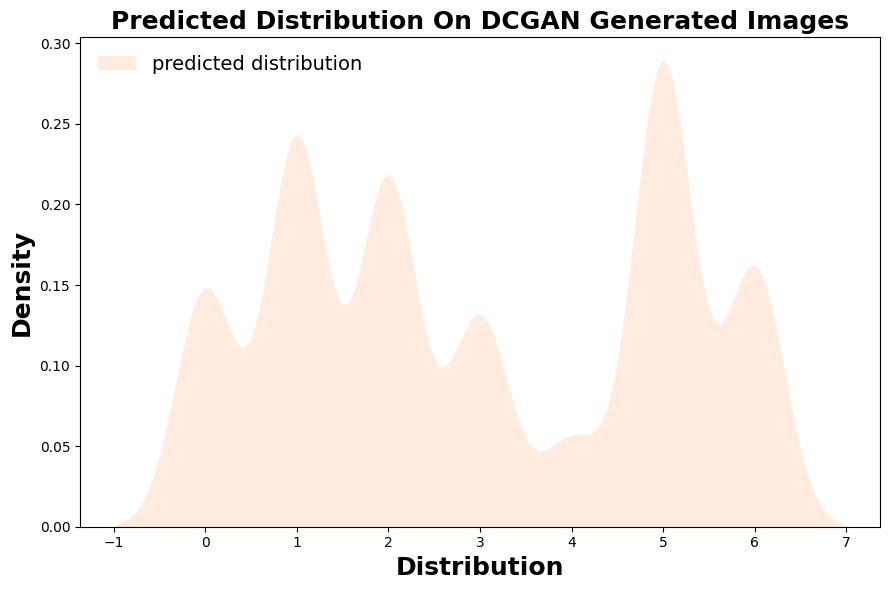

In [70]:
# Create a color palette
# colors = sns.color_palette("turbo", 2)
colors = sns.color_palette("pastel", 2)

# Set the figure size
plt.figure(figsize=(9, 6))

# Draw density graph
sns.kdeplot(DC_pred_labels, fill=True, color=colors[1], lw=0, label='predicted distribution')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize=14, frameon=False, edgecolor='black')
plt.xlabel('Distribution', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.title('Predicted Distribution On DCGAN Generated Images', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# distribution: predict nwsWgangp generated

In [71]:
nwsWgangp = DC_GAN_5(100, 28, 28, 3)
nwsWgangp.load_state_dict(torch.load('/content/nWS_WGANGP_l100_lr00001_epoch1000.pt'))
nwsWgangp.to(DEVICE)

DC_GAN_5(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 4, 4))
    (2): ConvTranspose2d(16, 112, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose2d(112, 224, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(224, 112, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): ConvTranspose2d(112, 56, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (12): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(ne

In [72]:
import random
manualSeed = 923
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

'''
generate fake images
'''
w_fake_images = nwsWgangp.generator_forward(fixed_noise).detach().cpu()
w_fake_images.shape # 3000, 28, 28, 3

# hyper parameters
BATCH_SIZE = 32

# batch size 32
wgan_generated_derma = DataLoader(w_fake_images, 
                         batch_size = BATCH_SIZE, 
                         num_workers=0,
                         shuffle=True)
# fake data is prepared

Random Seed:  923


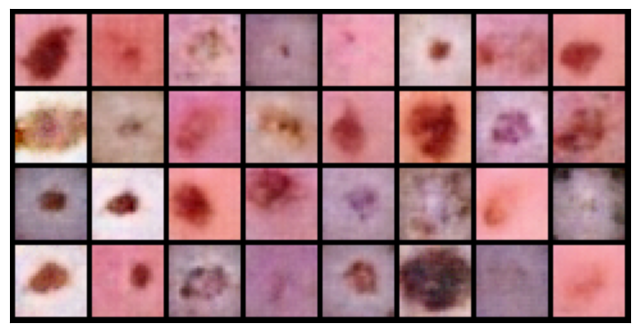

In [73]:
show_batch(wgan_generated_derma)

In [74]:
# predicted labels
w_pred_label = []
classifier.eval()
for i, generated_images in enumerate(wgan_generated_derma):
    # if torch.cuda.is_available():
    #     generated_images = generated_images.cuda()

    out = classifier(generated_images)
            
    _, pred_ = torch.max(out, axis=1)
    w_pred_label.append(pred_)
    
# get predicted labels
w_pred_labels = []
for i in range(len(w_pred_label)):
    for j in w_pred_label[i]:
        w_pred_labels.append(j.cpu().item())

w_pred_counts = pd.Series(w_pred_labels).value_counts()
w_pred_counts

5    6051
2    1826
1     713
4     505
0     418
3     410
6      77
dtype: int64

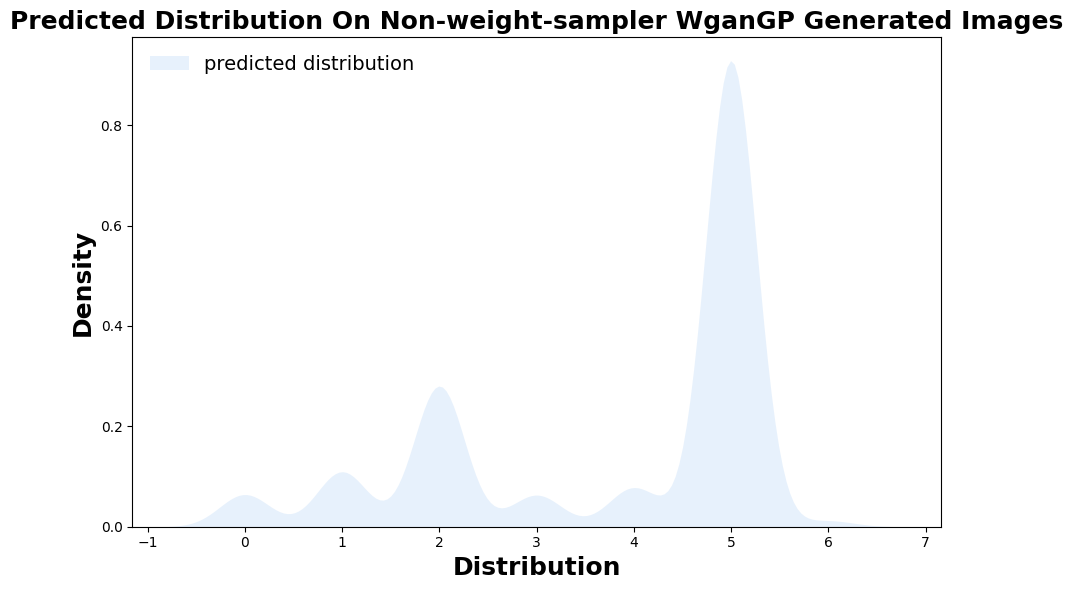

In [75]:
# Create a color palette
colors = sns.color_palette("pastel", 2)

# Set the figure size
plt.figure(figsize=(9, 6))

# Draw density graph
sns.kdeplot(w_pred_labels, fill=True, color=colors[0], lw=0, label='predicted distribution')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize=14, frameon=False, edgecolor='black')
plt.xlabel('Distribution', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.title('Predicted Distribution On Non-weight-sampler WganGP Generated Images', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Image-to-image comparison, a visualizaiton for real/fake images 
* label 1 and label 5
    * true images from the dataset
    * nWS WGANgp, classifier predicted, 
    * WS DCgan, classifier predicted


In [ ]:
# # compute the max value along dim=1 and check if it is greater than 0.8
# dc_max_values, dc_labels = torch.max(DC_softmax_concatenated, dim=1) # -> return for the max value of each row
# dc_mask = dc_max_values > 0.8

# # select the tensors where the max value is greater than 0.5
# dc_selected_tensors = DC_softmax_concatenated[dc_mask]

# # predicted labels
# dc_predicted_labels = dc_labels[dc_mask]

# # select the row indices where the max value is greater than 0.8
# dc_selected_indices = torch.nonzero(dc_mask).squeeze(1)

# # sort the selected tensors in descending order based on their max values
# dc_max_values_selected, _ = torch.max(dc_selected_tensors, dim=1)
# sorted_indices = torch.argsort(dc_max_values_selected, descending=True)

# # sort softmax tensors that are > 0.8
# dc_softmax_sorted = torch.index_select(dc_selected_tensors, 0, sorted_indices)

# # all label 1
# dc_indices_sorted = torch.index_select(dc_selected_indices, 0, sorted_indices)
# dc_labels_sorted = torch.index_select(dc_predicted_labels, 0, sorted_indices)

In [61]:
# for the above code, make a function
def indices_and_labels(softmax_matrix, threshold_value):

    max_values, labels = torch.max(softmax_matrix, dim=1) # -> return for the max value of each row
    
    # mask here return T/F for max_vlaues
    mask = max_values > threshold_value

    # accroding the T/F, choose rows from soft_matrix
    selected_tensors = softmax_matrix[mask]

    predicted_labels = labels[mask]

    # select index here using nonzero
    selected_indices = torch.nonzero(mask).squeeze(1)

    # sort the selected tensors in descending order based on their max values
    max_values_selected, _ = torch.max(selected_tensors, dim=1)
    sorted_indices = torch.argsort(max_values_selected, descending=True)

    # sort softmax tensors that are > 0.8
    softmax_sorted = torch.index_select(selected_tensors, 0, sorted_indices)

    # sort the correspoding indices
    indices_sorted = torch.index_select(selected_indices, 0, sorted_indices)
    labels_sorted = torch.index_select(predicted_labels, 0, sorted_indices)

    return indices_sorted, labels_sorted, softmax_sorted

In [62]:
# write a function to return corresponding index of wanted-label
def return_indices(indices, labels, want_label):

    zipped = zip(indices, labels)
    filtered_indices = torch.tensor([item[0] for item in zipped if item[1] == want_label])
    return filtered_indices

In [63]:
fid = FrechetInceptionDistance(feature=64,normalize=True)
AE = AutoEncoder()
AE.load_state_dict(torch.load('/content/AE.pt'))

<All keys matched successfully>

# DCgan generated

In [64]:
# dc_index = []
DC_softmax_list = []

classifier.eval()
for i, generated_images in enumerate(DC_generated_derma):
    DC_out = classifier(generated_images)
    DC_softmax = F.softmax(DC_out, dim=1)
    DC_softmax_list.append(DC_softmax)

# concatenate the softmax tensors in the list along the 0th dimension
DC_softmax_concatenated = torch.cat(DC_softmax_list, dim=0)      
# DC_softmax_concatenated.shape: 3000,7

# # check the softmatrix
# DC_softmax_concatenated

In [65]:
# 0.9 here is indicating images with 90% certainty
dc_indices, dc_labels, dc_tensors = indices_and_labels(DC_softmax_concatenated, 0.8)

# look at how many images for each label
unique_values, counts = torch.unique(dc_labels, return_counts=True)
print(unique_values)
print(counts)
# select the corresponding images using indices, we have  of them
# dc_fake_images[dc_indices].shape

tensor([1, 3, 4, 5, 6])
tensor([ 38, 158,   2, 364, 552])


In [66]:
len(dc_labels)
# dc_indices_sorted

1114

# 16 images of DCgan generated label6

552


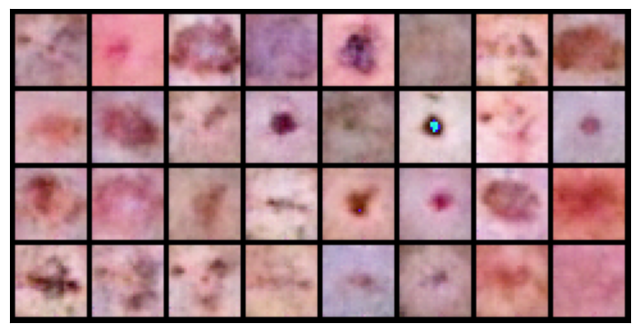

In [128]:
# fake 6
dc_img_index_6 = return_indices(dc_indices, dc_labels, 6)
print(len(dc_img_index_6))

# get the top8 certain label images
dc6_top = dc_fake_images[dc_img_index_6[0:32]]

torch_plot_tensor_figures(dc6_top, 4, 8)

In [126]:
# lets check 32 images of fake label6
# number_of_im = 32
# # data dictionary for plotting function
# dc6_top16_imgs = {'image'+str(i+1): dc6_top[i] for i in range(number_of_im)}
# data_check_plot_tensor_figures(dc6_top16_imgs, 4, 8)

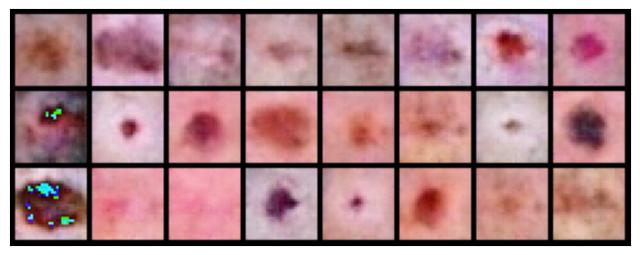

In [129]:
dc6_bad = dc_fake_images[dc_img_index_6[360:384]]
torch_plot_tensor_figures(dc6_bad, 4, 8)

# Real label6 

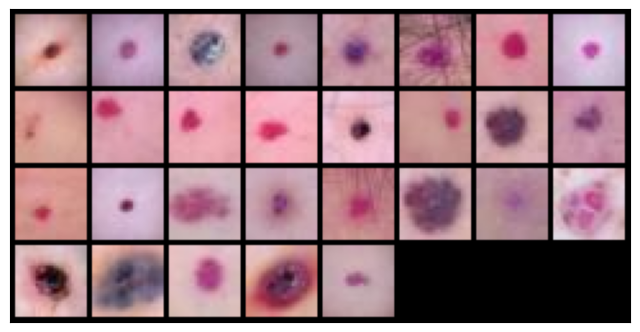

In [44]:
show_batch(visual6)

# Color Channel Distribution


## generated label6

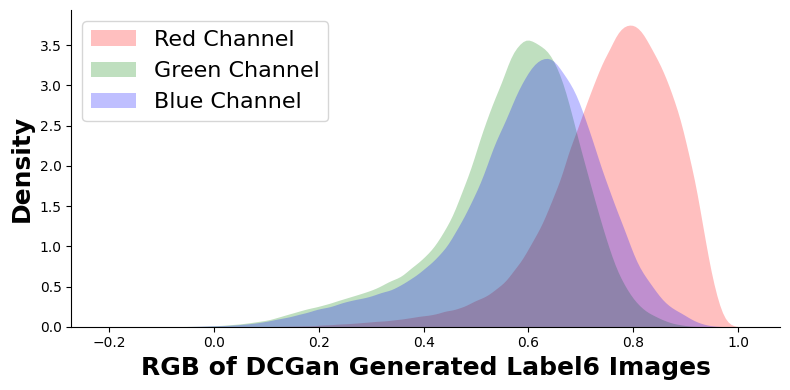

In [78]:
dc_6 = dc_fake_images[dc_img_index_6]
# Separate the color channels and reshape the array
dc_6r = dc_6[:, 0].flatten()
dc_6g = dc_6[:, 1].flatten()
dc_6b = dc_6[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': dc_6r, 'green': dc_6g, 'blue': dc_6b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label6 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## real label6

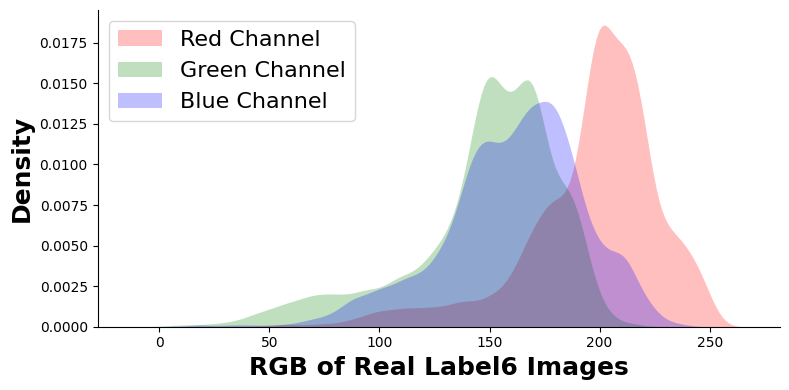

In [56]:
real6_ = test_data[index_[6]] # shape b, h, w, c
real6 = real6_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_6r = real6[:, 0].flatten()
real_6g = real6[:, 1].flatten()
real_6b = real6[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_6r, 'green': real_6g, 'blue': real_6b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label6 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# FID score

In [50]:
real6_tensor = torch.from_numpy(real6)
dc6_fid_list = []

for i in range(10):
    fid.update(real6_tensor, real=True)
    fid.update(dc_6, real=False)
    fid_dc6 = fid.compute()
    dc6_fid_list.append(fid_dc6.item())

print('the mean and std for FID: ', stat.mean(dc6_fid_list), stat.stdev(dc6_fid_list))

the mean and std for FID:  29.9947151184082 0.00037691555559327757


# Latent dimesion plot


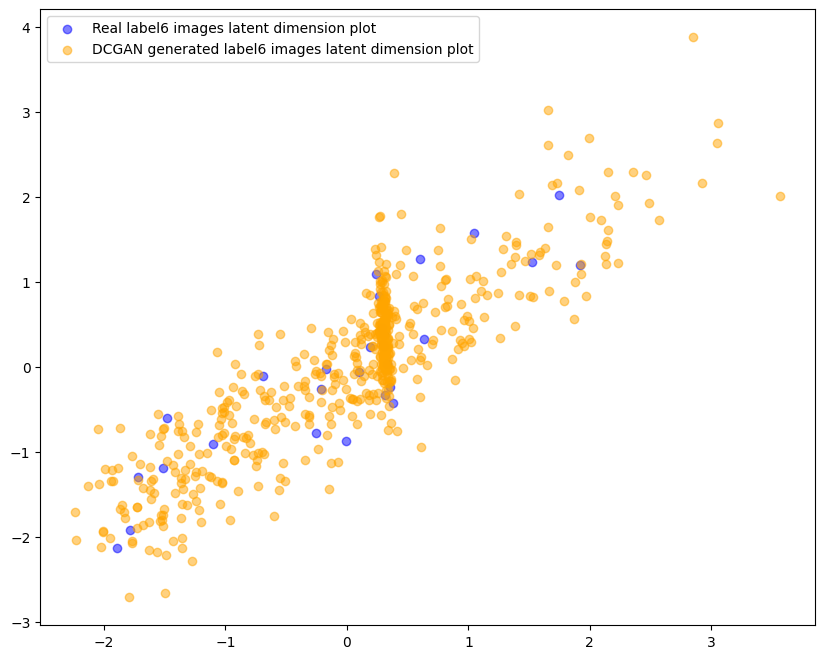

In [57]:
# batch size 32
real6_dl = DataLoader(real6,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

dc_6_dl = DataLoader(dc_6, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)
AE.eval()
r_emb6 = []
for i, images in enumerate(real6_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb6.append(embedding)
r_emb6_concatenated = torch.cat(r_emb6, dim=0) 
r_emb6_normalized = (r_emb6_concatenated - r_emb6_concatenated.mean(dim=0)) / r_emb6_concatenated.std(dim=0)

# extract the x and y coordinates
x6 = r_emb6_normalized[:, 0].detach().numpy()
y6 = r_emb6_normalized[:, 1].detach().numpy()

dc_emb6 = []
for i, images in enumerate(dc_6_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    dc_emb6.append(embedding)
dc_emb6_concatenated = torch.cat(dc_emb6, dim=0) 
dc_emb6_normalized = (dc_emb6_concatenated - dc_emb6_concatenated.mean(dim=0)) / dc_emb6_concatenated.std(dim=0)

# extract the x and y coordinates
dc_x6 = dc_emb6_normalized[:, 0].detach().numpy()
dc_y6 = dc_emb6_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x6, y6, color='blue', alpha=0.5, label='Real label6 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(dc_x6, dc_y6, color='orange', alpha=0.5, label='DCGAN generated label6 images latent dimension plot')
plt.legend()
plt.show()

# DCgan generated label5

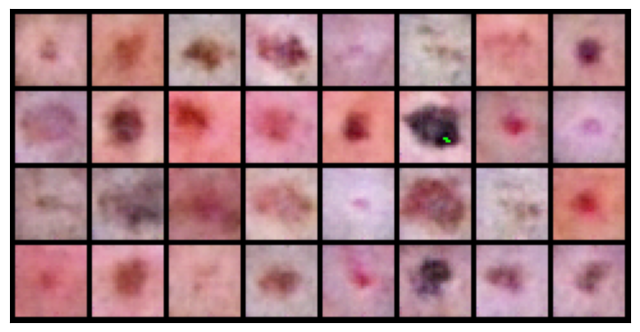

In [92]:
# fake 5
dc_img_index_5 = return_indices(dc_indices, dc_labels, 5)

# get the top certain label images
dc5_top = dc_fake_images[dc_img_index_5[0:32]]

# plot
torch_plot_tensor_figures(dc5_top, 4, 8)

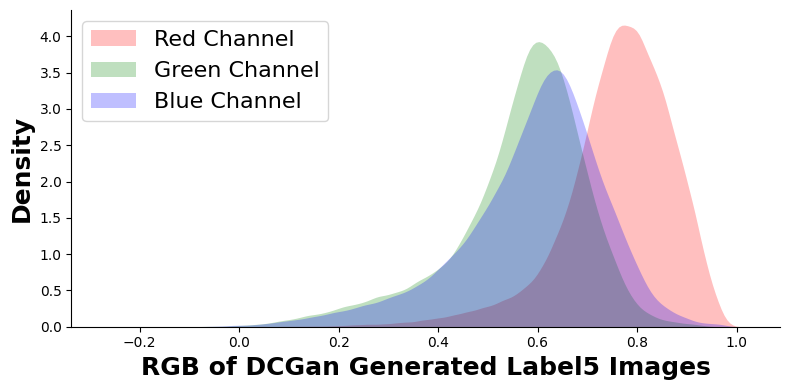

In [80]:
dc_5 = dc_fake_images[dc_img_index_5] # shape b,c,h,w
# Separate the color channels and reshape the array
dc_5r = dc_5[:, 0].flatten()
dc_5g = dc_5[:, 1].flatten()
dc_5b = dc_5[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': dc_5r, 'green': dc_5g, 'blue': dc_5b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label5 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Real label5

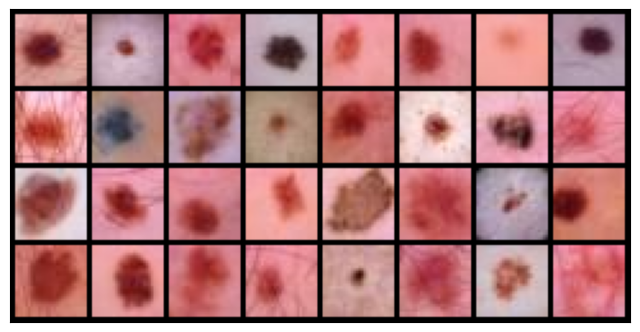

In [54]:
show_batch(visual5)

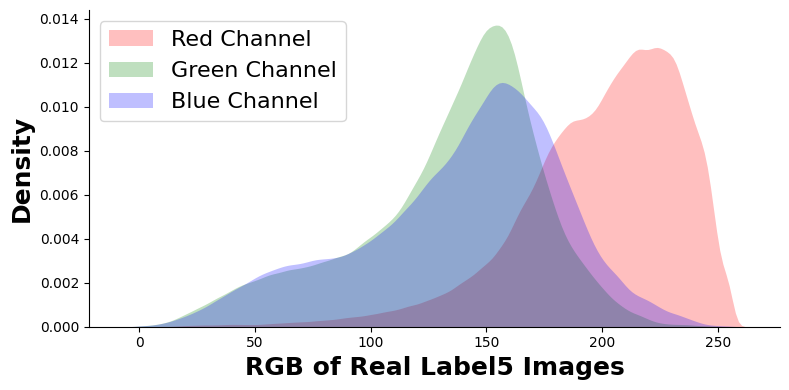

In [42]:
real5_ = test_data[index_[5]]
real5 = real5_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_5r = real5[:, 0].flatten()
real_5g = real5[:, 1].flatten()
real_5b = real5[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_5r, 'green': real_5g, 'blue': real_5b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label5 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# too expensive for this one
# do not execute 
real5_tensor = torch.from_numpy(real5)
dc5_fid_list = []

for i in range(10):
    fid.update(real5_tensor, real=True)
    fid.update(dc_5, real=False)
    fid_dc5 = fid.compute()
    dc5_fid_list.append(fid_dc5.item())

print('the mean and std for FID: ', stat.mean(dc5_fid_list), stat.stdev(dc5_fid_list))

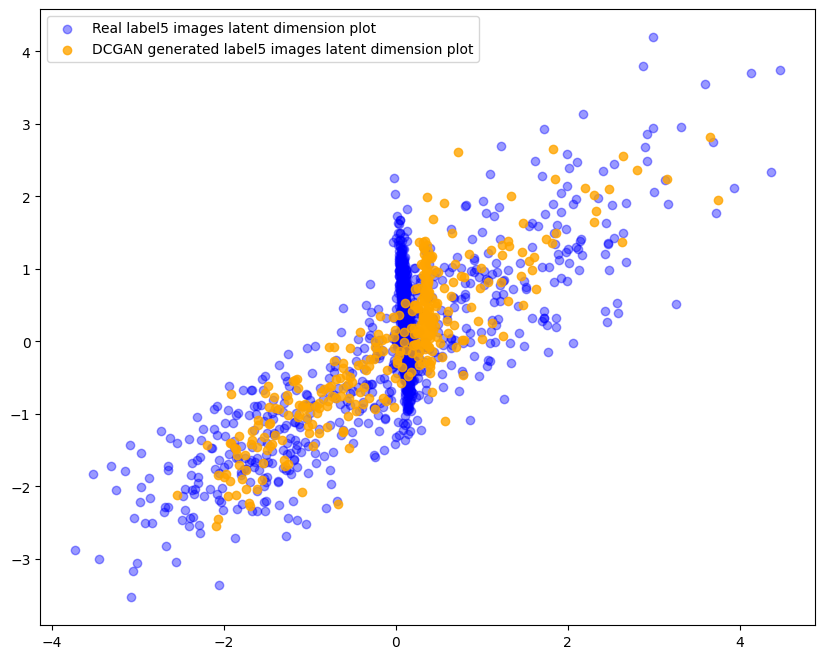

In [81]:
# batch size 32
real5_dl = DataLoader(real5,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

dc_5_dl = DataLoader(dc_5, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)
AE.eval()
r_emb5 = []
for i, images in enumerate(real5_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb5.append(embedding)
r_emb5_concatenated = torch.cat(r_emb5, dim=0) 
r_emb5_normalized = (r_emb5_concatenated - r_emb5_concatenated.mean(dim=0)) / r_emb5_concatenated.std(dim=0)

# extract the x and y coordinates
x5 = r_emb5_normalized[:, 0].detach().numpy()
y5 = r_emb5_normalized[:, 1].detach().numpy()

dc_emb5 = []
for i, images in enumerate(dc_5_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    dc_emb5.append(embedding)
dc_emb5_concatenated = torch.cat(dc_emb5, dim=0) 
dc_emb5_normalized = (dc_emb5_concatenated - dc_emb5_concatenated.mean(dim=0)) / dc_emb5_concatenated.std(dim=0)

# extract the x and y coordinates
dc_x5 = dc_emb5_normalized[:, 0].detach().numpy()
dc_y5 = dc_emb5_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x5, y5, color='blue', alpha=0.4, label='Real label5 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(dc_x5, dc_y5, color='orange', alpha=0.8, label='DCGAN generated label5 images latent dimension plot')
plt.legend()
plt.show()

# DCgan generated label3

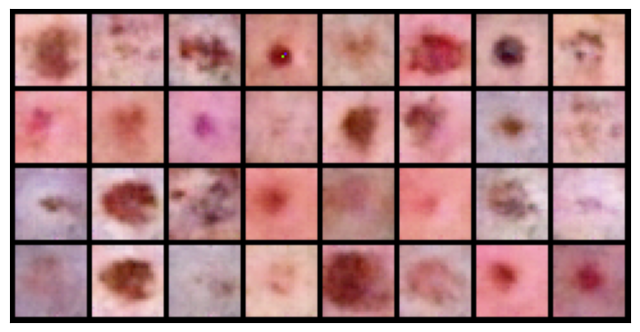

In [94]:
# fake 3
dc_img_index_3 = return_indices(dc_indices, dc_labels, 3)

# get the top certain label images
dc3_top = dc_fake_images[dc_img_index_3[0:32]]

# plot
torch_plot_tensor_figures(dc3_top, 4, 8)

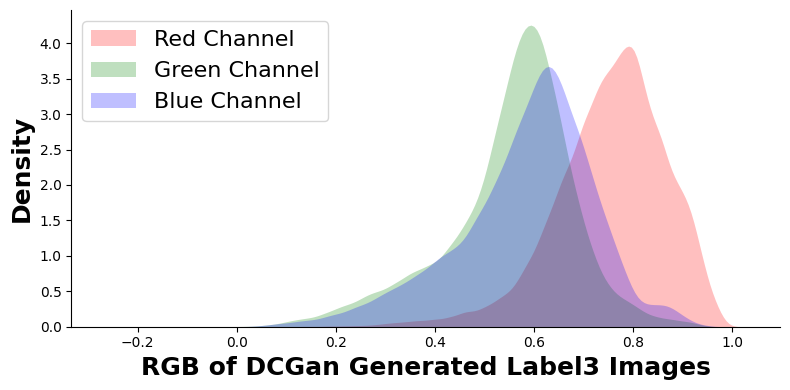

In [45]:
dc_3 = dc_fake_images[dc_img_index_3] # shape b,c,h,w
# Separate the color channels and reshape the array
dc_3r = dc_3[:, 0].flatten()
dc_3g = dc_3[:, 1].flatten()
dc_3b = dc_3[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': dc_3r, 'green': dc_3g, 'blue': dc_3b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label3 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Real label3

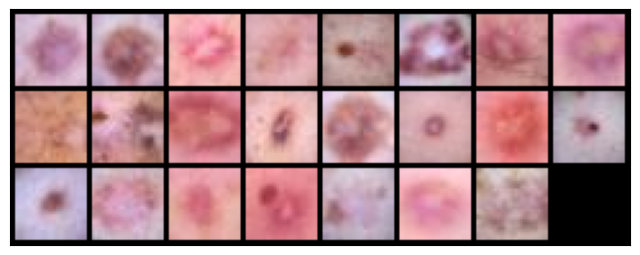

In [46]:
show_batch(visual3)

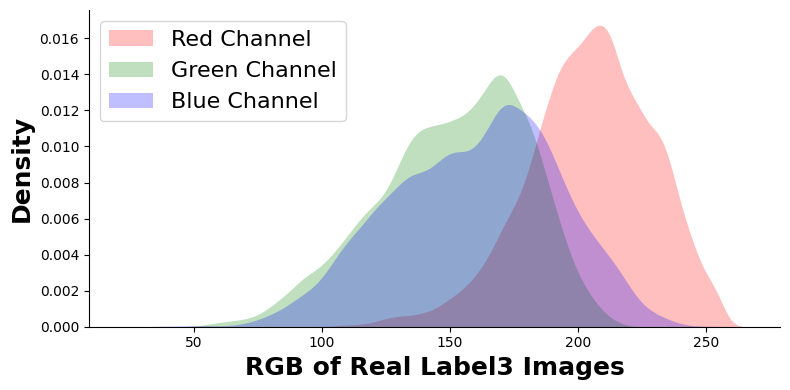

In [47]:
real3_ = test_data[index_[3]]
real3 = real3_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_3r = real3[:, 0].flatten()
real_3g = real3[:, 1].flatten()
real_3b = real3[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_3r, 'green': real_3g, 'blue': real_3b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label3 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

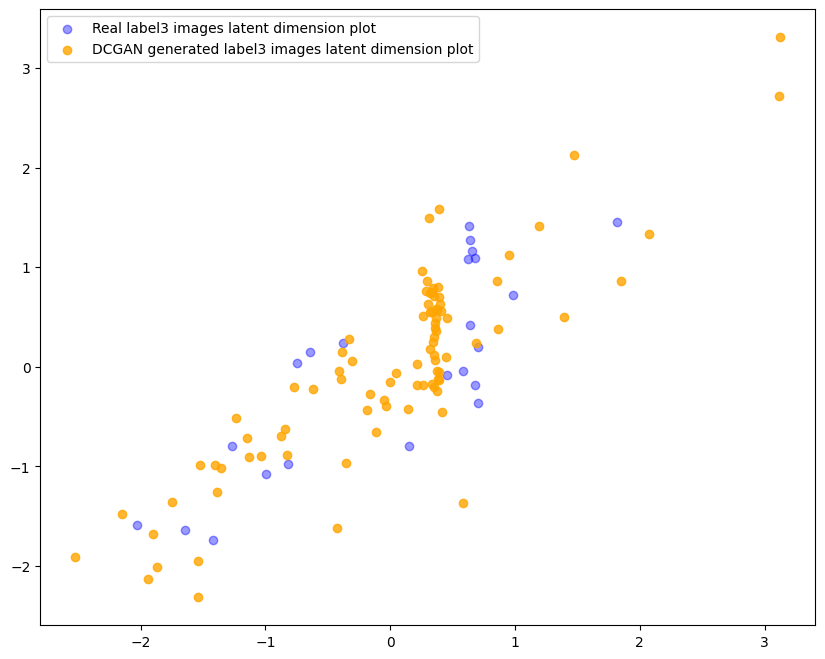

In [48]:
# batch size 32
real3_dl = DataLoader(real3,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

dc_3_dl = DataLoader(dc_3, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)
AE.eval()
r_emb3 = []
for i, images in enumerate(real3_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb3.append(embedding)
r_emb3_concatenated = torch.cat(r_emb3, dim=0) 
r_emb3_normalized = (r_emb3_concatenated - r_emb3_concatenated.mean(dim=0)) / r_emb3_concatenated.std(dim=0)

# extract the x and y coordinates
x3 = r_emb3_normalized[:, 0].detach().numpy()
y3 = r_emb3_normalized[:, 1].detach().numpy()

dc_emb3 = []
for i, images in enumerate(dc_3_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    dc_emb3.append(embedding)
dc_emb3_concatenated = torch.cat(dc_emb3, dim=0) 
dc_emb3_normalized = (dc_emb3_concatenated - dc_emb3_concatenated.mean(dim=0)) / dc_emb3_concatenated.std(dim=0)

# extract the x and y coordinates
dc_x3 = dc_emb3_normalized[:, 0].detach().numpy()
dc_y3 = dc_emb3_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x3, y3, color='blue', alpha=0.4, label='Real label3 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(dc_x3, dc_y3, color='orange', alpha=0.8, label='DCGAN generated label3 images latent dimension plot')
plt.legend()
plt.show()

# DCgan generated label1

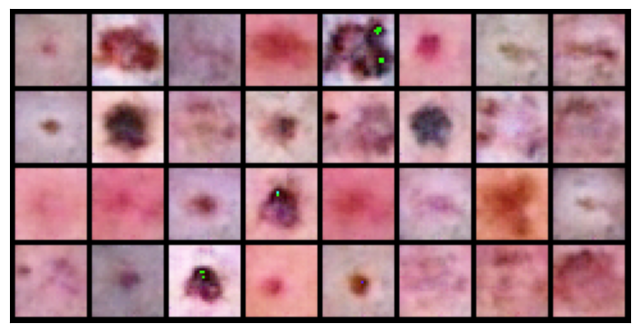

In [95]:
# fake 3
dc_img_index_1 = return_indices(dc_indices, dc_labels, 1)

# get the top certain label images
dc1_top = dc_fake_images[dc_img_index_1[0:32]]

# plot
torch_plot_tensor_figures(dc1_top, 4, 8)

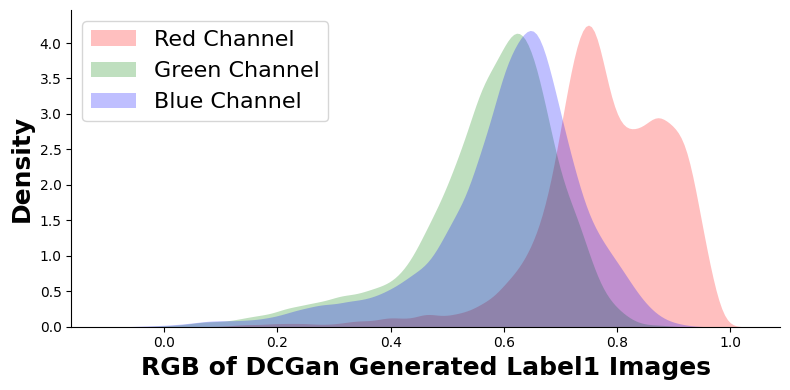

In [95]:
dc_1 = dc_fake_images[dc_img_index_1] # shape b,c,h,w
# Separate the color channels and reshape the array
dc_1r = dc_1[:, 0].flatten()
dc_1g = dc_1[:, 1].flatten()
dc_1b = dc_1[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': dc_1r, 'green': dc_1g, 'blue': dc_1b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label1 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Real label1

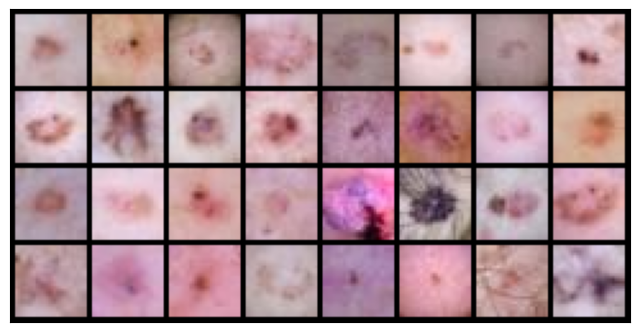

In [96]:
show_batch(visual1)

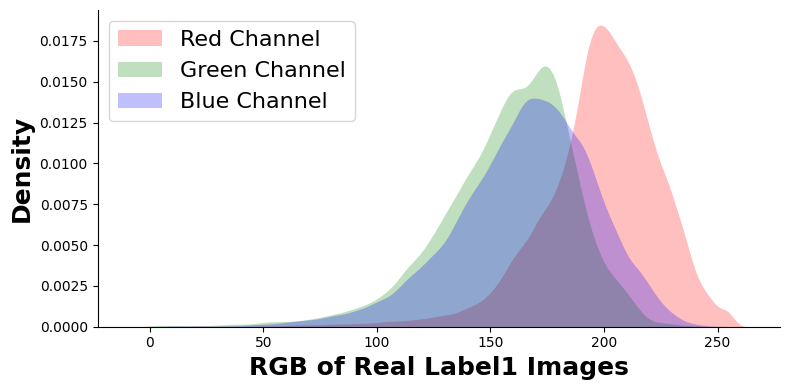

In [97]:
real1_ = test_data[index_[1]]
real1 = real1_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_1r = real1[:, 0].flatten()
real_1g = real1[:, 1].flatten()
real_1b = real1[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_1r, 'green': real_1g, 'blue': real_1b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label1 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

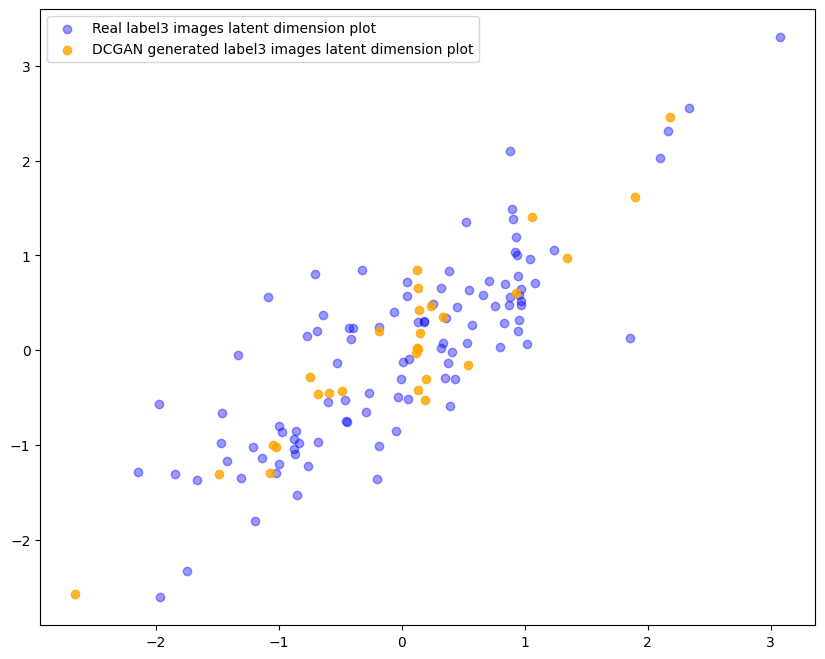

In [98]:
# batch size 32
real1_dl = DataLoader(real1,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

dc_1_dl = DataLoader(dc_1, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)
AE.eval()
r_emb1 = []
for i, images in enumerate(real1_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb1.append(embedding)
r_emb1_concatenated = torch.cat(r_emb1, dim=0) 
r_emb1_normalized = (r_emb1_concatenated - r_emb1_concatenated.mean(dim=0)) / r_emb1_concatenated.std(dim=0)

# extract the x and y coordinates
x1 = r_emb1_normalized[:, 0].detach().numpy()
y1 = r_emb1_normalized[:, 1].detach().numpy()

dc_emb1 = []
for i, images in enumerate(dc_1_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    dc_emb1.append(embedding)
dc_emb1_concatenated = torch.cat(dc_emb1, dim=0) 
dc_emb1_normalized = (dc_emb1_concatenated - dc_emb1_concatenated.mean(dim=0)) / dc_emb1_concatenated.std(dim=0)

# extract the x and y coordinates
dc_x1 = dc_emb1_normalized[:, 0].detach().numpy()
dc_y1 = dc_emb1_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x1, y1, color='blue', alpha=0.4, label='Real label3 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(dc_x1, dc_y1, color='orange', alpha=0.8, label='DCGAN generated label3 images latent dimension plot')
plt.legend()
plt.show()

# nWS Gan gp

In [99]:
AE = AutoEncoder()
AE.load_state_dict(torch.load('/content/AE.pt'))

<All keys matched successfully>

In [100]:
# dc_index = []
w_softmax_list = []

classifier.eval()
for i, generated_images in enumerate(wgan_generated_derma):
    w_out = classifier(generated_images)
    w_softmax = F.softmax(w_out, dim=1)
    w_softmax_list.append(w_softmax)

# concatenate the softmax tensors in the list along the 0th dimension
w_softmax_concatenated = torch.cat(w_softmax_list, dim=0)      
# w_softmax_concatenated.shape: 3000,7

# # check the softmatrix
# w_softmax_concatenated

In [101]:
# return sorted indices and labels from the original softmatrix
# choosing the max vlaues (pred) > 0.8, and sort in descending order
w_indices, w_labels, w_tensors = indices_and_labels(w_softmax_concatenated, 0.8)

# look at how many images for each label
w_unique_values, w_counts = torch.unique(w_labels, return_counts=True)
print(w_unique_values)
print(w_counts)
# select the corresponding images using indices, we have 429 of them
len(w_indices)

tensor([1, 2, 3, 5, 6])
tensor([  25,    1,   14, 1415,    2])


1457

# nWS WganGP genereated fake5

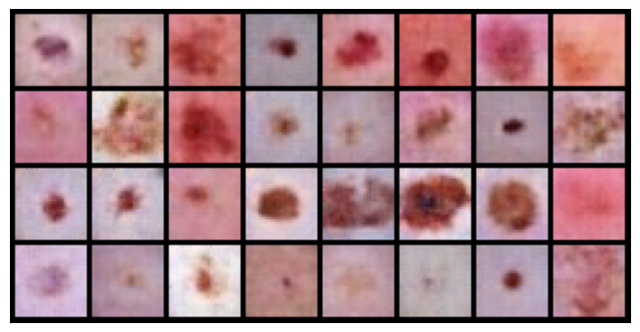

In [102]:
# fake 5 from wgan generated
w_img_index_5 = return_indices(w_indices, w_labels, 5)

# get the top certain label images
w5_top = w_fake_images[w_img_index_5[0:32]]

# plot
torch_plot_tensor_figures(w5_top, 4, 8)

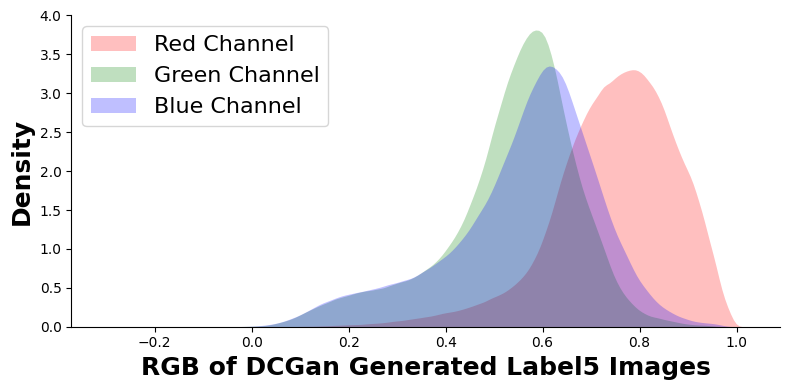

In [103]:
w_5 = w_fake_images[w_img_index_5] # shape b,c,h,w
# Separate the color channels and reshape the array
w_5r = w_5[:, 0].flatten()
w_5g = w_5[:, 1].flatten()
w_5b = w_5[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': w_5r, 'green': w_5g, 'blue': w_5b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label5 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Real label5 images

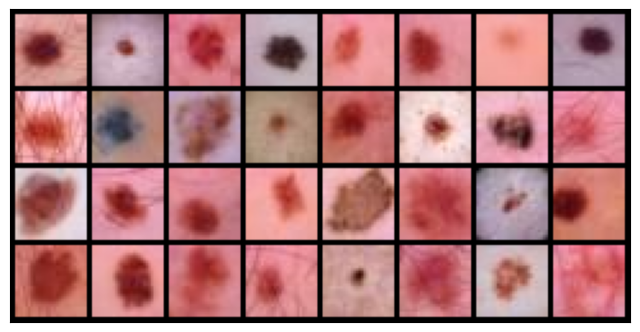

In [104]:
show_batch(visual5)

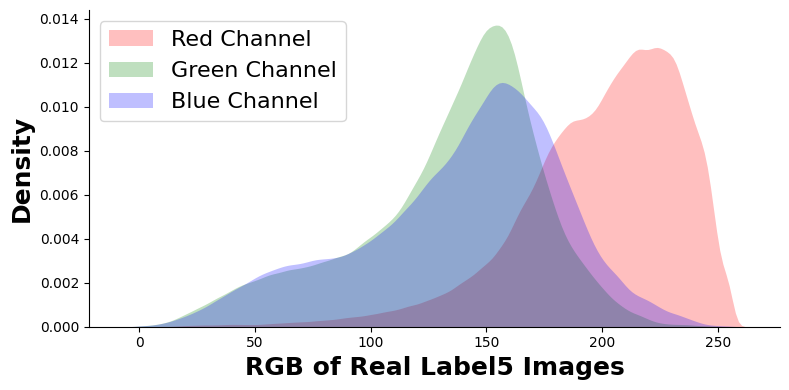

In [105]:
real5_ = test_data[index_[5]]
real5 = real5_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_5r = real5[:, 0].flatten()
real_5g = real5[:, 1].flatten()
real_5b = real5[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_5r, 'green': real_5g, 'blue': real_5b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label5 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
real5_tensor = torch.from_numpy(real5)
w5_fid_list = []

for i in range(10):
    fid.update(real5_tensor, real=True)
    fid.update(w_5, real=False)
    fid_w5 = fid.compute()
    w5_fid_list.append(fid_w5.item())

print('the mean and std for FID: ', stat.mean(w5_fid_list), stat.stdev(w5_fid_list))

## Encode data to 2-dim and plot 

In [106]:
# batch size 32
real5_dl = DataLoader(real5,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

w_5_dl = DataLoader(w_5, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)

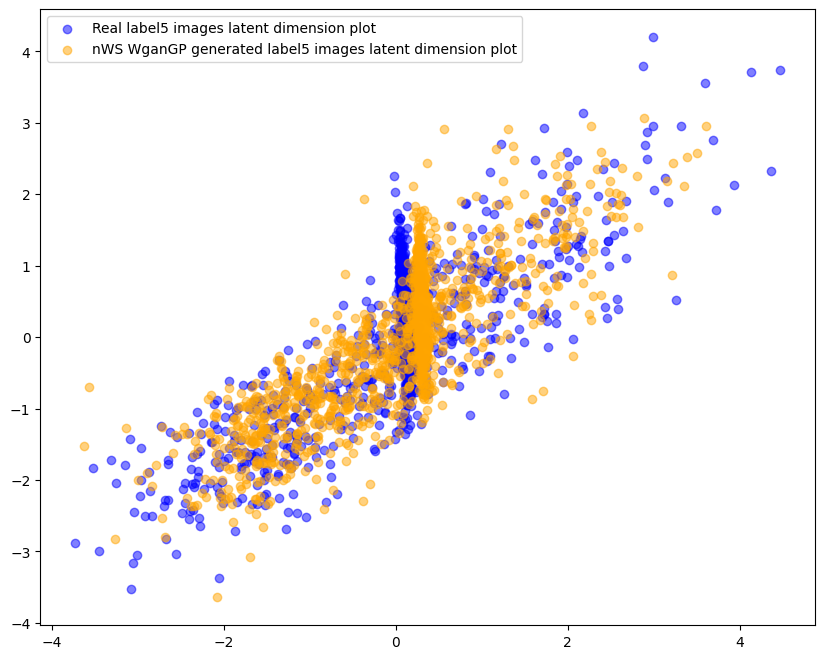

In [107]:
AE.eval()
r_emb5 = []
for i, images in enumerate(real5_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb5.append(embedding)
r_emb5_concatenated = torch.cat(r_emb5, dim=0) 
r_emb5_normalized = (r_emb5_concatenated - r_emb5_concatenated.mean(dim=0)) / r_emb5_concatenated.std(dim=0)

# extract the x and y coordinates
x5 = r_emb5_normalized[:, 0].detach().numpy()
y5 = r_emb5_normalized[:, 1].detach().numpy()

w_emb5 = []
for i, images in enumerate(w_5_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    w_emb5.append(embedding)
w_emb5_concatenated = torch.cat(w_emb5, dim=0) 
w_emb5_normalized = (w_emb5_concatenated - w_emb5_concatenated.mean(dim=0)) / w_emb5_concatenated.std(dim=0)

# extract the x and y coordinates
w_x5 = w_emb5_normalized[:, 0].detach().numpy()
w_y5 = w_emb5_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x5, y5, color='blue', alpha=0.5, label='Real label5 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(w_x5, w_y5, color='orange', alpha=0.5, label='nWS WganGP generated label5 images latent dimension plot')
plt.legend()
plt.show()

# nWS WganGP genereated fake1

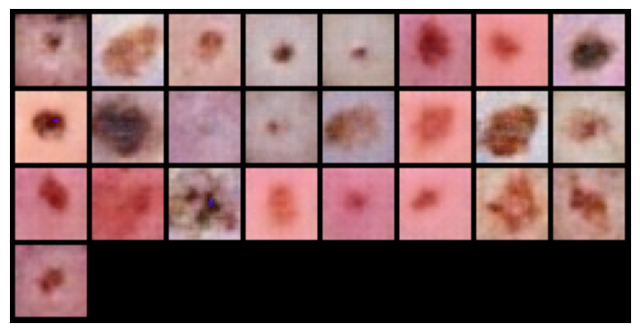

In [108]:
# fake 3
w_img_index_1 = return_indices(w_indices, w_labels, 1)

# get the top certain label images
w1_top = w_fake_images[w_img_index_1[0:32]]

# plot
torch_plot_tensor_figures(w1_top, 4, 8)

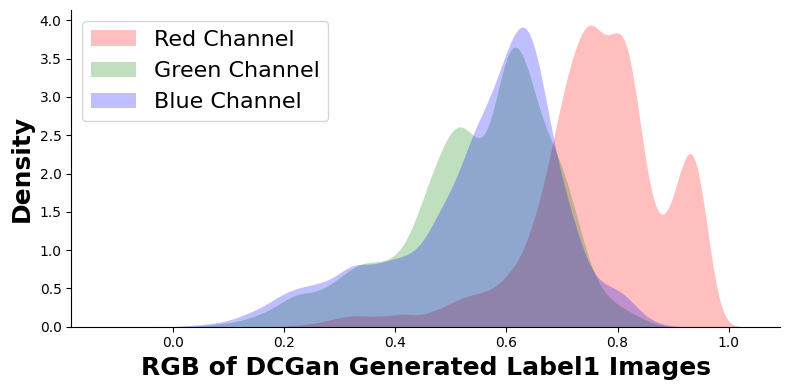

In [109]:
w_1 = w_fake_images[w_img_index_1] # shape b,c,h,w
# Separate the color channels and reshape the array
w_1r = w_1[:, 0].flatten()
w_1g = w_1[:, 1].flatten()
w_1b = w_1[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': w_1r, 'green': w_1g, 'blue': w_1b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of DCGan Generated Label1 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Real label1 images

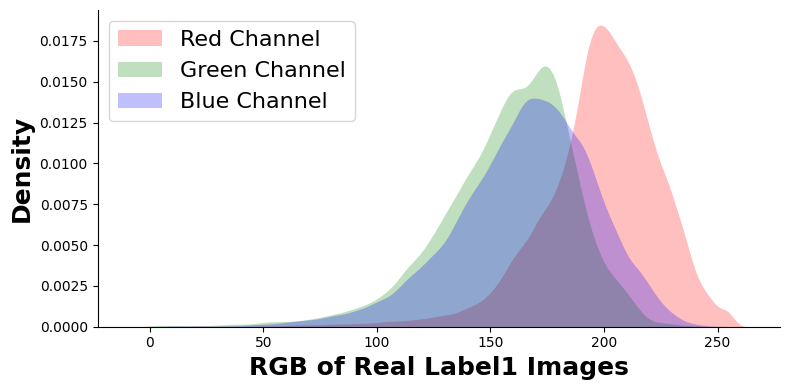

In [110]:
real1_ = test_data[index_[1]] # shape b, h, w, c
real1 = real1_.transpose(0,3,1,2)
# Separate the color channels and reshape the array
real_1r = real1[:, 0].flatten()
real_1g = real1[:, 1].flatten()
real_1b = real1[:, 2].flatten()

# Create a grid of subplots and plot the density plots
g = sns.FacetGrid(pd.DataFrame({'red': real_1r, 'green': real_1g, 'blue': real_1b}),
                  aspect=2, height=4)
g.map(sns.kdeplot, 'red', color='red', fill=True, lw=0, label='Red Channel')
g.map(sns.kdeplot, 'green', color='green', fill=True, lw=0, label='Green Channel')
g.map(sns.kdeplot, 'blue', color='blue', fill=True, lw=0, label='Blue Channel')

# Add legends and adjust the plot layout
plt.legend(loc='upper left', fontsize = 16)
plt.xlabel('RGB of Real Label1 Images', fontsize=18, fontweight='bold')
plt.ylabel('Density', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# FID score

In [ ]:
real1_tensor = torch.from_numpy(real1)
w1_fid_list = []

for i in range(10):
    fid.update(real1_tensor, real=True)
    fid.update(w_1, real=False)
    fid_w1 = fid.compute()
    w1_fid_list.append(fid_w1.item())

print('the mean and std for FID: ', stat.mean(w1_fid_list), stat.stdev(w1_fid_list))

the mean and std for FID:  29.45783634185791 0.00013723620463393417


# Latent dimension plot

In [111]:
# batch size 32
real1_dl = DataLoader(real1,
                      batch_size = BATCH_SIZE,
                      shuffle=False)

w_1_dl = DataLoader(w_1, 
                    batch_size = BATCH_SIZE, 
                    num_workers=0,
                    shuffle=False)

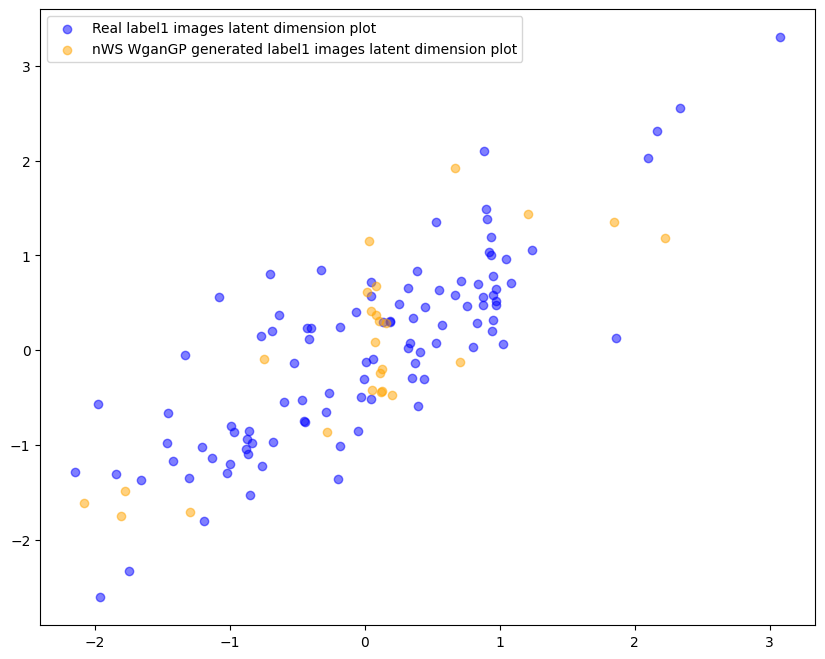

In [112]:
AE.eval()
r_emb1 = []
for i, images in enumerate(real1_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    r_emb1.append(embedding)
r_emb1_concatenated = torch.cat(r_emb1, dim=0) 
r_emb1_normalized = (r_emb1_concatenated - r_emb1_concatenated.mean(dim=0)) / r_emb1_concatenated.std(dim=0)

# extract the x and y coordinates
x1 = r_emb1_normalized[:, 0].detach().numpy()
y1 = r_emb1_normalized[:, 1].detach().numpy()

w_emb1 = []
for i, images in enumerate(w_1_dl):
    images = images.to(torch.float32)
    embedding = AE.encoder(images)
    w_emb1.append(embedding)
w_emb1_concatenated = torch.cat(w_emb1, dim=0) 
w_emb1_normalized = (w_emb1_concatenated - w_emb1_concatenated.mean(dim=0)) / w_emb1_concatenated.std(dim=0)

# extract the x and y coordinates
w_x1 = w_emb1_normalized[:, 0].detach().numpy()
w_y1 = w_emb1_normalized[:, 1].detach().numpy()

plt.figure(figsize=(10,8))
# Plot real5 data in blue
plt.scatter(x1, y1, color='blue', alpha=0.5, label='Real label1 images latent dimension plot')
# Plot w_5 data in orange
plt.scatter(w_x1, w_y1, color='orange', alpha=0.5, label='nWS WganGP generated label1 images latent dimension plot')
plt.legend()
plt.show()